In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import bernoulli
from scipy.ndimage import rotate

In [2]:
# Read data file
df = pd.read_csv('data/ch2_train_center_cam.csv')

## Check out an image

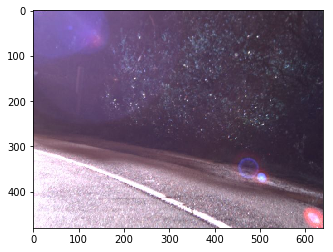

In [3]:
img = cv.imread('data/ch2_train_center/1479424610768911885.png', 1)
plt.imshow(img)

In [4]:
# Check out associated label
data = df.loc[df['filename']=='center/1479424610768911885.png']
steering_angle = data.angle.values.squeeze()
print('label = ', steering_angle)

label =  41.067423994354094


# Image Utils

In [5]:
def imgCenterCrop(img, crop_size):
    """
    Crop source img
    
    :param img: source img
    
    :param crop_size: ints tuple
        size of cropped img
        
    :return: cropped img
    """
    crop_height, crop_width = crop_size 
    w_l = np.int32((img.shape[1] - crop_width) / 2)
    return img[img.shape[0] - crop_height:, w_l: w_l + crop_width]


def imgRandomFlip(img, steering_angle, flipping_prob=0.5):
    """
    Flip a coin, if head -> flip the image. If the image is flipped
    the steering angle is flipped sign
    
    :param img: original image
    
    :param steering_angle: original steering angle
    
    :param flipping_prob:
    
    :return:
        (flipped) image, (flipped) steering angle
    
    """
    head = bernoulli.rvs(flipping_prob)
    if head:
        return np.fliplr(img), -1 * steering_angle
    else:
        return img, steering_angle
    

def imgRandomAdjustGamma(img):
    """
    Randomly apply gamma correction on img to adjust its brightness
    
    :param img: source image
    """
    gamma = np.random.uniform(0.4, 1.5)
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8") 
    
    # apply gamma correction using lookup table
    return cv.LUT(img, table)


def imgRandomShear(img, steering_angle, shear_range=200):
    """
    Source:  https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.7k8vfppvk

    :param img: source img
    
    :param steering_angle: associate steering_angle
    
    :param shear_range: random shear between [-shear_range, shear_range + 1]

    :return:
        sheared img & sheared steering angle
    """
    if len(img.shape) > 2:
        rows, cols, ch = img.shape
    else:
        rows, cols = img.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv.getAffineTransform(pts1, pts2)
    img = cv.warpAffine(img, M, (cols, rows), borderMode=1)
    steering_angle += dsteering

    return img, steering_angle


def imgRandomRotate(img, steering_angle, max_rotation=15):
    """
    Rotate input image
    
    :param img: source img
    
    :param steering_angle: assoc. steering_angle
    
    :return:
        Rotated img & rotated steering angle
    """
    rot_angle = np.random.uniform(-max_rotation, max_rotation + 1) * np.pi / 180
    return rotate(img, rot_angle, reshape=False), steering_angle - rot_angle


def imgPreprocess(img, steering_angle, crop_size=(300, 400), shear_prob=0.75, resize=(128, 128)):
    """
    Apply all random treatment on source image
    
    :return:
        pre-processed img & its associate steering angle
    """
    # crop 
    img = imgCenterCrop(img, crop_size)
    
    # adjust brightness
    img = imgRandomAdjustGamma(img)
    
    # randomly flip
    img, steering_angle = imgRandomFlip(img, steering_angle)
    
    # randomly rotate
    img, steering_angle = imgRandomRotate(img, steering_angle)
    
    # randomly shear
    head = bernoulli.rvs(shear_prob)
    if head:
        img, steering_angle = imgRandomShear(img, steering_angle)
    
    return cv.resize(img, resize), steering_angle

# Train Utils

In [6]:
STEERING_COEFFICIENT = 0.229  # to calculate steering angle associate with (left/ right) camera 

In [22]:
def trainGetImgFiles(batch_idx, batch_size=64):
    """
    Extract name of image files & associate steering angle
    from dataframe starting from the (batch_idx * batch_size)-th row
    
    :param batch_idx: int
        which rows to start getting img path & steering angle
        
    :param batch_size:
    
    :param global df: 
        dataframe object storing csv file
        
    :return:
        List of tuples of frame_id(which camera), img_path & steering angle
    """
    path_prefix = 'data/'
    _batch = []
    row_0 = batch_idx * batch_size
    for i in range(min(batch_size, len(df) - row_0)):
        frame_id = df.loc[row_0 + i].frame_id
        img_path = path_prefix + df.loc[row_0 + i].filename
        steering_angle = df.loc[row_0 + i].angle
        _batch.append((frame_id, img_path, steering_angle))

    return _batch


def trainGenerateBatch(batch_idx, batch_size=64, color_mode=0):
    """
    Generate batch for training.
    
    :param batch_idx: int
        which rows to start getting img path & steering angle
        
    :param batch_size:
    
    :param color_mode:
        1: color img, 0: grayscale img 
    
    :param global df: 
        dataframe object storing csv file
        
    :return:
        List of tuples of preprocessid imgs & assoc. steering angle
    """
    # read csv & extract frame_id, path to img file, steering angle
    _batch = trainGetImgFiles(batch_idx, batch_size)
    
    batch_X = []  # features
    batch_y = []  # labels
    
    # preprocess img & steering angle 
    for _frame_id, _path, _steering in _batch:
        # get raw image
        _img = cv.imread(_path, color_mode)  
        
        # adjust steering angle if img is obtained by side camera
        if _frame_id == 'left_camera':
            _steering -= STEERING_COEFFICIENT
        elif _frame_id == 'right_camera':
            _steering += STEERING_COEFFICIENT
        
        # manipulate img & steering 
        img, steering = imgPreprocess(_img, _steering)
        
        batch_X.append(img)
        batch_y.append(steering)
    
    return batch_X, batch_y

        

([array([[[36, 28, 39],
        [31, 25, 35],
        [33, 28, 37],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[31, 26, 36],
        [30, 25, 35],
        [32, 27, 37],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[29, 24, 34],
        [29, 24, 34],
        [29, 24, 34],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[78, 71, 82],
        [86, 82, 93],
        [73, 68, 80],
        ...,
        [42, 32, 54],
        [40, 30, 52],
        [40, 30, 52]],

       [[70, 63, 76],
        [84, 80, 91],
        [69, 64, 76],
        ...,
        [44, 34, 56],
        [39, 29, 52],
        [39, 29, 51]],

       [[70, 63, 75],
        [67, 61, 72],
        [62, 57, 69],
        ...,
        [27, 20, 35],
        [30, 23, 38],
        [29, 22, 37]]], dtype=uint8)], [48.93190223513109])


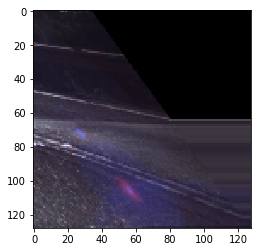

In [26]:
batch = trainGenerateBatch(0, 1, color_mode=1)
print(batch)
plt.imshow(batch[0][0])

In [10]:
shuffle_df = df.sample(frac=1).reset_index(drop=True)

In [16]:
shuffle_df.loc[0]

Unnamed: 0                             15837
index          2016-11-17 23:14:43.046628140
timestamp                1479424483046628140
width                                    640
height                                   480
frame_id                       center_camera
filename      center/1479424483046628140.png
angle                                20.2333
torque                                 1.875
speed                                21.1972
lat                                  37.5112
long                                -122.351
alt                                  58.8714
keep                                    True
Name: 0, dtype: object